# Running a Recipe Locally
Welcome to the Pangeo Forge introduction tutorial! This is the 2nd part in a sequence, the flow of which is described {doc}`here </introduction_tutorial/index>`.


### Code from Part 1
You'll need the `FilePattern` that was created in Part 1 to work on Part 2.  The Part 1 code is copied here.

In [1]:
import pandas as pd

from pangeo_forge_recipes.patterns import ConcatDim, FilePattern
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

dates = pd.date_range('2012-01-01', '2019-11-01', freq='D')

def make_url(time):
    yyyy = time.strftime('%Y')
    yyyymmdd = time.strftime('%Y%m%d')
    return (
        'https://coastwatch.noaa.gov/pub/socd/lsa/rads/sla/daily/dt'
        f'/{yyyy}/rads_global_dt_sla_{yyyymmdd}_001.nc'
    )

time_concat_dim = ConcatDim("time", dates, nitems_per_file=1)
pattern = FilePattern(make_url, time_concat_dim)

## Part 2 Outline

The main goal of the first two parts of this tutorial are to create and run a **recipe**, the object that defines our data transformation. 

In part 2 of this tutorial we wil be using the `FilePattern` we defined in Part 1 to create a recipe and use it to create some cloud optimized data on our own computer!

The steps to doing this are:
1. Create the Recipe object
1. Set up logging
1. Prune the recipe
1. Run the recipe
1. Check output data

Step 1 creates the recipe, steps 2-4 run the recipe, and in step 5 we look at the output of the recipe run. It's all about the recipe. 📃🍰🥧


## Create the Recipe object

While the `FilePattern` object for this dataset took several steps, the [Recipe Class](https://pangeo-forge.readthedocs.io/en/latest/recipe_user_guide/recipes.html) comes pretty quickly. We want to convert our dataset to zarr, so we will use the `XarrayZarrRecipe` class. Implementing the class looks like this:

In [2]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe

recipe = XarrayZarrRecipe(pattern, inputs_per_chunk=)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 2862}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x1120d9850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpi08t9389/EPoO1or7'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x1120d9850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpi08t9389/1q23n459'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x1120d9850>, root_path='/var/folders/f8/rh42xb3d1tnbw2bxsjwgym1c0000gn/T/tmpi08t9389/f7UCRSYj')), inputs_per_chunk=40, target_chunks={}, cache_inputs=True, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={}, open_input_with_fsspec_reference=False)

The arguments are:
1. the `FilePattern` object
2. `inputs_per_chunk` - indicates how many files should go into a single chunk of the zarr store. 

Here we choose a value of 20 because each Coastwatch SLA file is ~3MB, resulting approximately 100MB chunks. We can check how big each file is by downloading it from the source URL, explored in Part 1.

In more complex recipes additional arguments may get used, but for this tutorial these two are all we need.

## Set up logging

It's often useful for debugging to turn on logging, which will print additional statements of output while the recipe runs. Logs produce a finer scale update of the downloading, organizing, and converting that happens behind the scenes while a recipe is run.

In [3]:
from pangeo_forge_recipes.recipes import setup_logging

In [4]:
setup_logging()

## Prune the recipe

Currently our recipe is set up to convert over 3 decades worth of data. That is much more data than we need to run a test (and probably more data than fits on our computer). What we want instead is to run a subset of the data, just to make sure the recipe is working. 

Pangeo Forge has a built in function for getting a smaller test-appropriate chunk. The `.copy_pruned()` function duplicates the recipe it is called on and outputs a new recipe object that references just a subset of the data. `.copy_pruned()` is used mainly for testing. 

In [5]:
recipe_pruned = recipe.copy_pruned()

We can see that our new recipe object, `recipe_pruned`, is smaller than the original `recipe` by looking at the `FilePattern` associated with each one. The original `recipe` object has 14,764 time steps, while the new `recipe_pruned` has just two.

In [6]:
recipe.file_pattern

<FilePattern {'time': 2862}>

In [7]:
recipe_pruned.file_pattern

<FilePattern {'time': 2}>

## Run the recipe

The time is here, to run the recipe! There are [multiple ways](https://pangeo-forge.readthedocs.io/en/latest/recipe_user_guide/execution.html) to run the recipe. Here we are going to use the `.to_function()` method to convert our recipe object into a Python function. The output of this method is an actual Python function with the name of the variable you assigned (a function that _creates_ a function!). It can be run like any other function in Python - by using `()`.

In [8]:
run_function = recipe_pruned.to_function()

In [9]:
run_function()

[03/04/22 10:45:21] INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=929270;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=405421;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=0, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>)})'                             

                    INFO     Caching file 'https://coastwatch.noaa.gov/pub/soc ]8;id=847410;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=383571;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             d/lsa/rads/sla/daily/dt/2012/rads_global_dt_sla_2               
                             0120101_001.nc'                                                 

                    INFO     Copying remote file 'https://coastwatch.noaa.gov/ ]8;id=977478;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=87455;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             pub/socd/lsa/rads/sla/daily/dt/2012/rads_global_d               
                             t_sla_20120101_001.nc' to cache                                 

[03/04/22 10:45:22] INFO     Caching input 'Index({DimIndex(name='time',   ]8;id=944252;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=836265;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#149\149]8;;\
                             index=1, sequence_len=2,                                        
                             operation=<CombineOp.CONCAT: 2>)})'                             

                    INFO     Caching file 'https://coastwatch.noaa.gov/pub/soc ]8;id=425877;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=687937;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#154\154]8;;\
                             d/lsa/rads/sla/daily/dt/2012/rads_global_dt_sla_2               
                             0120102_001.nc'                                                 

                    INFO     Copying remote file 'https://coastwatch.noaa.gov/ ]8;id=508103;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=499226;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#165\165]8;;\
                             pub/socd/lsa/rads/sla/daily/dt/2012/rads_global_d               
                             t_sla_20120102_001.nc' to cache                                 

/Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py:111: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())


                    INFO     Creating a new dataset in target              ]8;id=298549;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=678674;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#451\451]8;;\

                    INFO     Opening inputs for chunk                      ]8;id=367390;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=938069;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=791839;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=972928;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://coastwatch.noaa.gov/pub/socd/                   
                             lsa/rads/sla/daily/dt/2012/rads_global_dt_sla                   
                             _20120101_001.nc'                                               

                    INFO     Opening 'https://coastwatch.noaa.gov/pub/socd/lsa ]8;id=33491;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=778719;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             /rads/sla/daily/dt/2012/rads_global_dt_sla_201201               
                             01_001.nc' from cache                                           

                    INFO     Opening input with Xarray                     ]8;id=962902;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=812550;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://coastwatch.noaa.gov/pub/socd/                   
                             lsa/rads/sla/daily/dt/2012/rads_global_dt_sla                   
                             _20120102_001.nc'                                               

                    INFO     Opening 'https://coastwatch.noaa.gov/pub/socd/lsa ]8;id=547393;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=554346;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             /rads/sla/daily/dt/2012/rads_global_dt_sla_201201               
                             02_001.nc' from cache                                           

                    INFO     Combining inputs for chunk                    ]8;id=945570;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=976947;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing dataset in /var/folders/f8/rh42xb3d1t ]8;id=908903;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=721197;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#493\493]8;;\
                             nbw2bxsjwgym1c0000gn/T/tmpi08t9389/EPoO1or7                     

                    INFO     Expanding target concat dim 'time' to size 2  ]8;id=223837;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=862923;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#507\507]8;;\

                    INFO     Opening inputs for chunk                      ]8;id=283506;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=261877;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#333\333]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=531103;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=357924;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://coastwatch.noaa.gov/pub/socd/                   
                             lsa/rads/sla/daily/dt/2012/rads_global_dt_sla                   
                             _20120101_001.nc'                                               

                    INFO     Opening 'https://coastwatch.noaa.gov/pub/socd/lsa ]8;id=800184;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=214645;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             /rads/sla/daily/dt/2012/rads_global_dt_sla_201201               
                             01_001.nc' from cache                                           

[03/04/22 10:45:23] INFO     Opening input with Xarray                     ]8;id=271793;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=337969;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#249\249]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=2, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://coastwatch.noaa.gov/pub/socd/                   
                             lsa/rads/sla/daily/dt/2012/rads_global_dt_sla                   
                             _20120102_001.nc'                                               

                    INFO     Opening 'https://coastwatch.noaa.gov/pub/socd/lsa ]8;id=154458;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py\storage.py]8;;\:]8;id=885888;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/storage.py#260\260]8;;\
                             /rads/sla/daily/dt/2012/rads_global_dt_sla_201201               
                             02_001.nc' from cache                                           

                    INFO     Combining inputs for chunk                    ]8;id=604750;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=234703;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#351\351]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

/Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/chunk_grid.py:51: UserWarning: chunksize (40) > dimsize (2). Decreasing chunksize to 2
  warnings.warn(


                    INFO     Storing variable crs chunk                    ]8;id=662978;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=685626;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),)                       

                    INFO     Storing variable lon_bnds chunk               ]8;id=38971;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=637247;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

                    INFO     Storing variable lat_bnds chunk               ]8;id=449083;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=341391;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

                    INFO     Storing variable time chunk                   ]8;id=468655;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=253327;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),)                       

                    INFO     Storing variable time_bnds chunk              ]8;id=154988;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=427834;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),                        
                             slice(None, None, None))                                        

                    INFO     Storing variable sla chunk                    ]8;id=111754;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=787359;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

                    INFO     Storing variable ugos chunk                   ]8;id=987883;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=113860;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

                    INFO     Storing variable vgos chunk                   ]8;id=686463;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=310078;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#570\570]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 2, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None))                                                          

                    INFO     Consolidating dimension coordinate arrays     ]8;id=238168;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=534303;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#587\587]8;;\

                    INFO     Consolidating Zarr metadata                   ]8;id=544574;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=423587;file:///Users/rwegener/repos/pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#611\611]8;;\

## Check output

Now that the process has run we can use `xarray` to inspect the output data. The `.target_mapper` property of a recipe object tells us where the data is stored. We can use that, along with the `xr.open_zarr()` function of `xarray`, to open up the new dataset.

In [10]:
import xarray as xr

In [13]:
sla_zarr = xr.open_zarr(recipe.target_mapper, consolidated=True)
sla_zarr

<xarray.Dataset>
Dimensions:    (time: 2, latitude: 720, nv: 2, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 2012-01-01 2012-01-02
Dimensions without coordinates: nv
Data variables:
    crs        (time) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(2, 720, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(2, 1440, 2), meta=np.ndarray>
    sla        (time, latitude, longitude) float32 dask.array<chunksize=(2, 720, 1440), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(2, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(2, 720, 1440), meta=np.ndarray>
Attributes: (12/26)
    Conventions:                     CF-1.6
    creator_email:                   Eric.Leuliette@noaa.gov
    creator_name:                    Eric.Leuliette@noaa.gov
    cw:processing_algorithm:         RADS 4.3.5
    cw:product_status:               Experimental
    cw:satellite:                    Jason-1\nJason-2\nCryoSat-2
    ...                              ...
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    institution:                     NOAA/NESDIS Center for Satellite Applica...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v2.0
    source:                          Altimetry measurements
    title:                           Daily merged sea surface height anomalie...

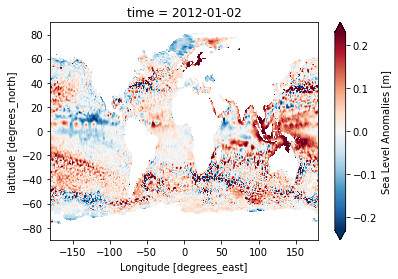

In [26]:
sla_zarr['sla'].sel(time='2012-01-02').plot(robust=True)

There it is! Some zarr data that we created during this tutorial! We have converted the netCDF ESA SSS data to zarr and opened it up in xarray. We have a working local recipe.

If we wanted to run the recipe on the full dataset (as opposed to the much smaller pruned version), we would just repeat the above steps on recipe rather than recipe_pruned. This would take a long time, but it would work.

## End of Part 2

In this part of the tutorial we took the `FilePattern` defined in Part 1 and ran it on our local machine to produce some zarr Coastwatch SLA data. We created the recipe, set up logging, pruned the recipe, and ran the recipe with the `.to_function()` method. We then used `xarray` to check the output.

Part 2 completes the features of the `pangeo-forge-recipe` library that we will be looking at in this tutorial sequence. It's important to note - `pangeo-forge-recipes` is a stand alone library that could be run to create ARCO data without utilizing any of the cloud aspects of Pangeo Forge.

Utilizing the cloud is a really powerful aspect of Pangeo Forge, however, so in the next part of the tutorial we will be moving on to how we take our local recipe and get it set up for Pangeo Forge Cloud.

### Code Summary

The code written in part 2 could all be written together as:

In [ ]:
import xarray as xr

from pangeo_forge_recipes.recipes import XarrayZarrRecipe
from pangeo_forge_recipes.recipes import setup_logging

# Create recipe object
recipe = XarrayZarrRecipe(pattern, inputs_per_chunk=2)

# Set up logging
setup_logging()

# Prune the recipe
recipe_pruned = recipe.copy_pruned()

# Run the recipe
run_function = recipe_pruned.to_function()
run_function()

# Check the output
sss_zarr = xr.open_zarr(recipe.target_mapper, consolidated=True)
sss_zarr

In [19]:
dnld_sla = xr.open_dataset('./rads_global_dt_sla_20120101_001.nc')

In [25]:
dnld_sla['sla'].plot(robust=True)

<xarray.DataArray 'sla' ()>
array(-1.1886, dtype=float32)